In [1]:
import numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [7]:
train, val, test, data = (np.load("../data/task1_%s.npz" % f)
                    for f in ("train", "val", "test", "data"))
xtr, ytr, xval, yval, xte, yte, xdata, ydata = (
  torch.from_numpy(arr).float()
  for arr in (train["x"], train["y"], val["x"], val["y"], test["x"], test["y"], data["x"], data["y"])
)

# xtr has the format (num households, sequence length, input dim)
xtr.shape, ytr.shape

(torch.Size([50, 287, 7]), torch.Size([50, 287]))

In [3]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = 7

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

In [33]:
class RNN(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = 7

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x is expected to be of shape (B, L)
        assert x.ndim == 2

        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # input should be (N,L,Hin) since batch_first=True
        # (N, L, 1)
        x = x[..., None] # (B, L, 1)
        # Propagate input through LSTM
        _, h_out = self.rnn(x, h_0)
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)

        return out

In [14]:
num_epochs = 3000
learning_rate = 0.01

input_size = 1
hidden_size = 32
num_layers = 1

num_classes = 1

#lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
rnn = RNN(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
#optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

x = xtr[0]
x = x[..., None]
y = ytr[0]
y = y[...,None]

# Train the model
for epoch in range(num_epochs):
    #outputs = lstm(x)
    outputs = rnn(x)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, y)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 983.76001
Epoch: 100, loss: 138.55713
Epoch: 200, loss: 75.49258
Epoch: 300, loss: 62.34100
Epoch: 400, loss: 58.86347
Epoch: 500, loss: 53.90973
Epoch: 600, loss: 51.81826
Epoch: 700, loss: 52.58271
Epoch: 800, loss: 48.26755
Epoch: 900, loss: 46.94173
Epoch: 1000, loss: 45.63363
Epoch: 1100, loss: 46.05360
Epoch: 1200, loss: 46.85191
Epoch: 1300, loss: 43.74771
Epoch: 1400, loss: 43.59484
Epoch: 1500, loss: 43.20514
Epoch: 1600, loss: 43.85965
Epoch: 1700, loss: 45.01289
Epoch: 1800, loss: 43.14763
Epoch: 1900, loss: 42.38416
Epoch: 2000, loss: 48.25616
Epoch: 2100, loss: 41.99455
Epoch: 2200, loss: 42.83629
Epoch: 2300, loss: 41.86645
Epoch: 2400, loss: 40.60469
Epoch: 2500, loss: 49.72710
Epoch: 2600, loss: 41.93556
Epoch: 2700, loss: 40.08340
Epoch: 2800, loss: 40.03119
Epoch: 2900, loss: 42.90757


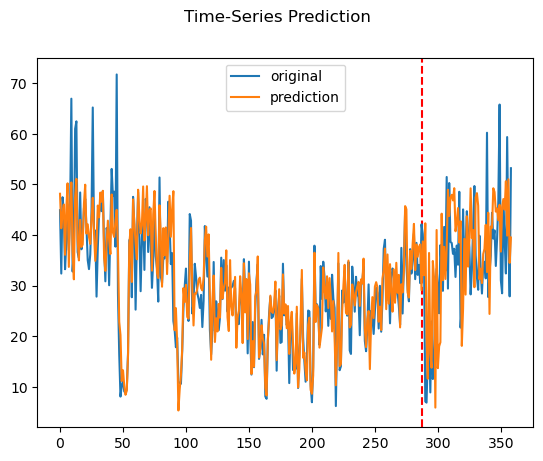

In [6]:
#lstm.eval()
rnn.eval()

xd= xdata[0][...,None]
#train_predict = lstm(xd)
train_predict = rnn(xd)

data_predict = train_predict.data.numpy()
dataY_plot = ydata[0].data.numpy()

training_length = int(len(xd)*0.8)
plt.axvline(x=training_length, c='r', linestyle='--')

plt.plot(dataY_plot, label="original")
plt.plot(data_predict, label="prediction")
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()

### Federated learning

In [39]:
num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 32
num_layers = 1

num_classes = 1

#lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
rnn = RNN(num_classes, input_size, hidden_size, num_layers)
train_losses, val_losses = [], []

criterion = torch.nn.MSELoss()    # mean-squared error for regression
#optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

B = 2 ** 6
N = xtr.shape[1]
H = 1 # len(xtr)
# Train the model
model = rnn # or lstm
for epoch in range(num_epochs):
    optimizer.zero_grad()
    train_losses.append([epoch, 0.])
    for household_ix in range(H):
      # xtr: (num households, sequence length, input dim)
      # xtr: (H: num households, N: number of train samples, L: sequence length)
      # xtr: (H, N, L)
      # xtr[household_ix]: (N, L)
      # xtr[household_ix, ..., None]: (N, L, 1)
      batch_ix = torch.randint(0, N, (B,))
      xb = xtr[household_ix, batch_ix, ...] # (B, L)
      yb = ytr[household_ix, batch_ix] # (B,)
      
      outputs = model(xb)
      y = yb.unsqueeze(-1) # (B, 1)
      loss = criterion(outputs, y)
      train_losses[-1][1] += loss.item()

      loss.backward() # sum up gradients in parameters
    
    # average losses from different households
    train_losses[-1][1] = train_losses[-1][1] / H
    for p in model.parameters():
      p.grad = p.grad / H

    optimizer.step()
    if epoch % 100 == 0:
      with torch.no_grad():
        # y_pred is of shape (H * N,)
        y_pred = model(
            # (H, N, L) -> (H * N, L)
            xval.reshape(-1, xval.shape[-1])
        )
        y_gt = yval.reshape(-1, 1)
        val_loss = criterion(y_pred, y_gt)
        val_losses.append([epoch, val_loss.item()])
        
      print("Epoch: %d,  train loss: %1.5f, val loss: %1.5f" % (epoch, loss.item(), val_loss.item()))

Epoch: 0,  train loss: 1160.71960, val loss: 642.74860
Epoch: 100,  train loss: 107.52905, val loss: 191.66783
Epoch: 200,  train loss: 99.44921, val loss: 71.48843
Epoch: 300,  train loss: 62.67414, val loss: 77.51850
Epoch: 400,  train loss: 48.62340, val loss: 65.85124
Epoch: 500,  train loss: 67.98637, val loss: 72.83128
Epoch: 600,  train loss: 56.80465, val loss: 71.24072
Epoch: 700,  train loss: 66.33717, val loss: 75.92092
Epoch: 800,  train loss: 74.88416, val loss: 70.37046
Epoch: 900,  train loss: 64.14177, val loss: 73.65538


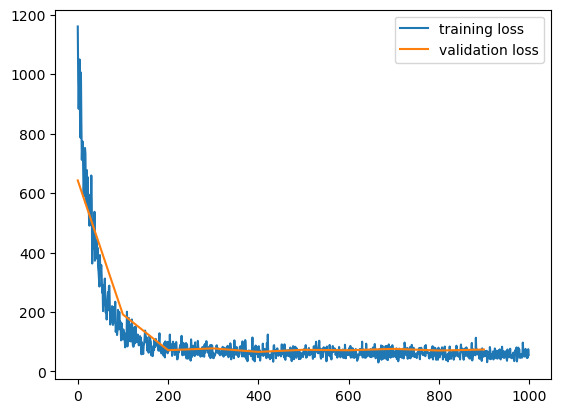

In [41]:
plt.plot(*zip(*train_losses), label="training loss")
plt.plot(*zip(*val_losses), label="validation loss")
plt.legend();